## Showing min variance and efficient portfolio

In [46]:
import datetime as dt
import numpy as np
import pandas as pd
from numpy import dot
from numpy import divide
from numpy.linalg import multi_dot as mdot
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
#import quadprog
import yfinance
plt.style.use('seaborn')
plt.rcParams.update({
   "text.usetex": True,
   "font.family": ['Latin Modern Roman'],
   "xtick.labelsize": 17.0,
   "ytick.labelsize": 17.0,
   "axes.labelsize":  17.0,
   "legend.fontsize": 17.0
})

### Downloading historical data

In [57]:
spx = pd.read_csv('../data/spx.csv').stack().tolist()

In [58]:
raw_data = yfinance.download(spx, start="2013-1-1", end="2021-10-02", back_adjust=True, auto_adjust=True)
closing_prices = raw_data['Close']
r_f = 0.0
returns = closing_prices.pct_change().iloc[1:].ffill()-((1+r_f)**(1/250)-1)

[*********************100%***********************]  504 of 504 completed

14 Failed downloads:
- VAR: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- MXIM: No data found, symbol may be delisted
- CXO: No data found, symbol may be delisted
- MYL: No data found, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- NBL: No data found, symbol may be delisted
- COG: No data found, symbol may be delisted
- CTL: No data found, symbol may be delisted
- LB: No data found, symbol may be delisted
- BF.B: None
- ALXN: No data found, symbol may be delisted
- FLIR: No data found, symbol may be delisted
- TIF: No data found, symbol may be delisted


### Calculating annual expected return $\mu$ and volatility $\sigma$

In [59]:
returns = returns.ffill()
returns = returns.dropna(axis = 1, how = 'any')
returns = returns*100
mu = returns.mean()*250
std = returns.std()*(250**0.5)

### Calculating minimum variance portfolio

In [60]:
Sigma = returns.cov().values
Sigma_inv = inv(Sigma)
one = np.ones((len(Sigma_inv)))

In [61]:
v_t_mvp = dot(Sigma_inv, one)/mdot([one.T, Sigma_inv, one])

### Using numerical solver

In [ ]:
res = quadprog.solve_qp(G=Sigma, a = np.zeros(len(Sigma_inv)), C = np.ones((len(Sigma_inv), 1)), b=np.ones(1), meq=1)

### Calculating efficient portfolio

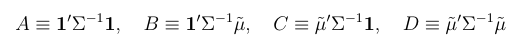

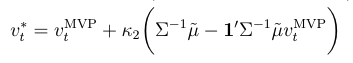

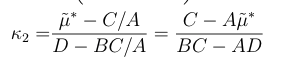

In [62]:
expected_mu_mvp = (v_t_mvp.T*returns).sum(axis=1).mean()*250

In [63]:
A = mdot([one.T, Sigma_inv, one])
B = mdot([one.T, Sigma_inv, mu])
#C = mdot([mu_tilde.T, Sigma_inv, one])
#D = mdot([mu_tilde.T, Sigma_inv, mu_tilde])

_lambda = 100

def efficient_port(mu, _lambda):
    v_t_eff = v_t_mvp + 1/_lambda*(dot(Sigma_inv, mu)-dot(divide(B, A), dot(Sigma_inv, one)))
    return v_t_eff

v_t_eff = efficient_port(mu, _lambda)

### Applying the two mutual fund theorem

In [64]:
def port_std(weights):
    return mdot([weights.T, Sigma, weights])*(250**0.5)

In [65]:
#frontier_weights = [efficient_port(c) for c in np.arange(expected_mu_mvp, 250, 1)]
#frontier_mu = [dot(mu_tilde.T, w) for w in frontier_weights]
#frontier_std = [port_std(w) for w in frontier_weights]

frontier_weights = [efficient_port(mu, l) for l in np.arange(30, 2000, .5)]
frontier_mu = [dot(mu.T, w) for w in frontier_weights]
frontier_std = [port_std(w) for w in frontier_weights]

### Lower part of efficient frontier

In [66]:
# Not defined when using lambda
lower_frontier_weights = [efficient_port(mu, l) for l in np.arange(-2000, -20, .5)]
lower_frontier_mu = [dot(mu.T, w) for w in lower_frontier_weights]
lower_frontier_std = [port_std(w) for w in lower_frontier_weights]

### Ilustation of feasible set

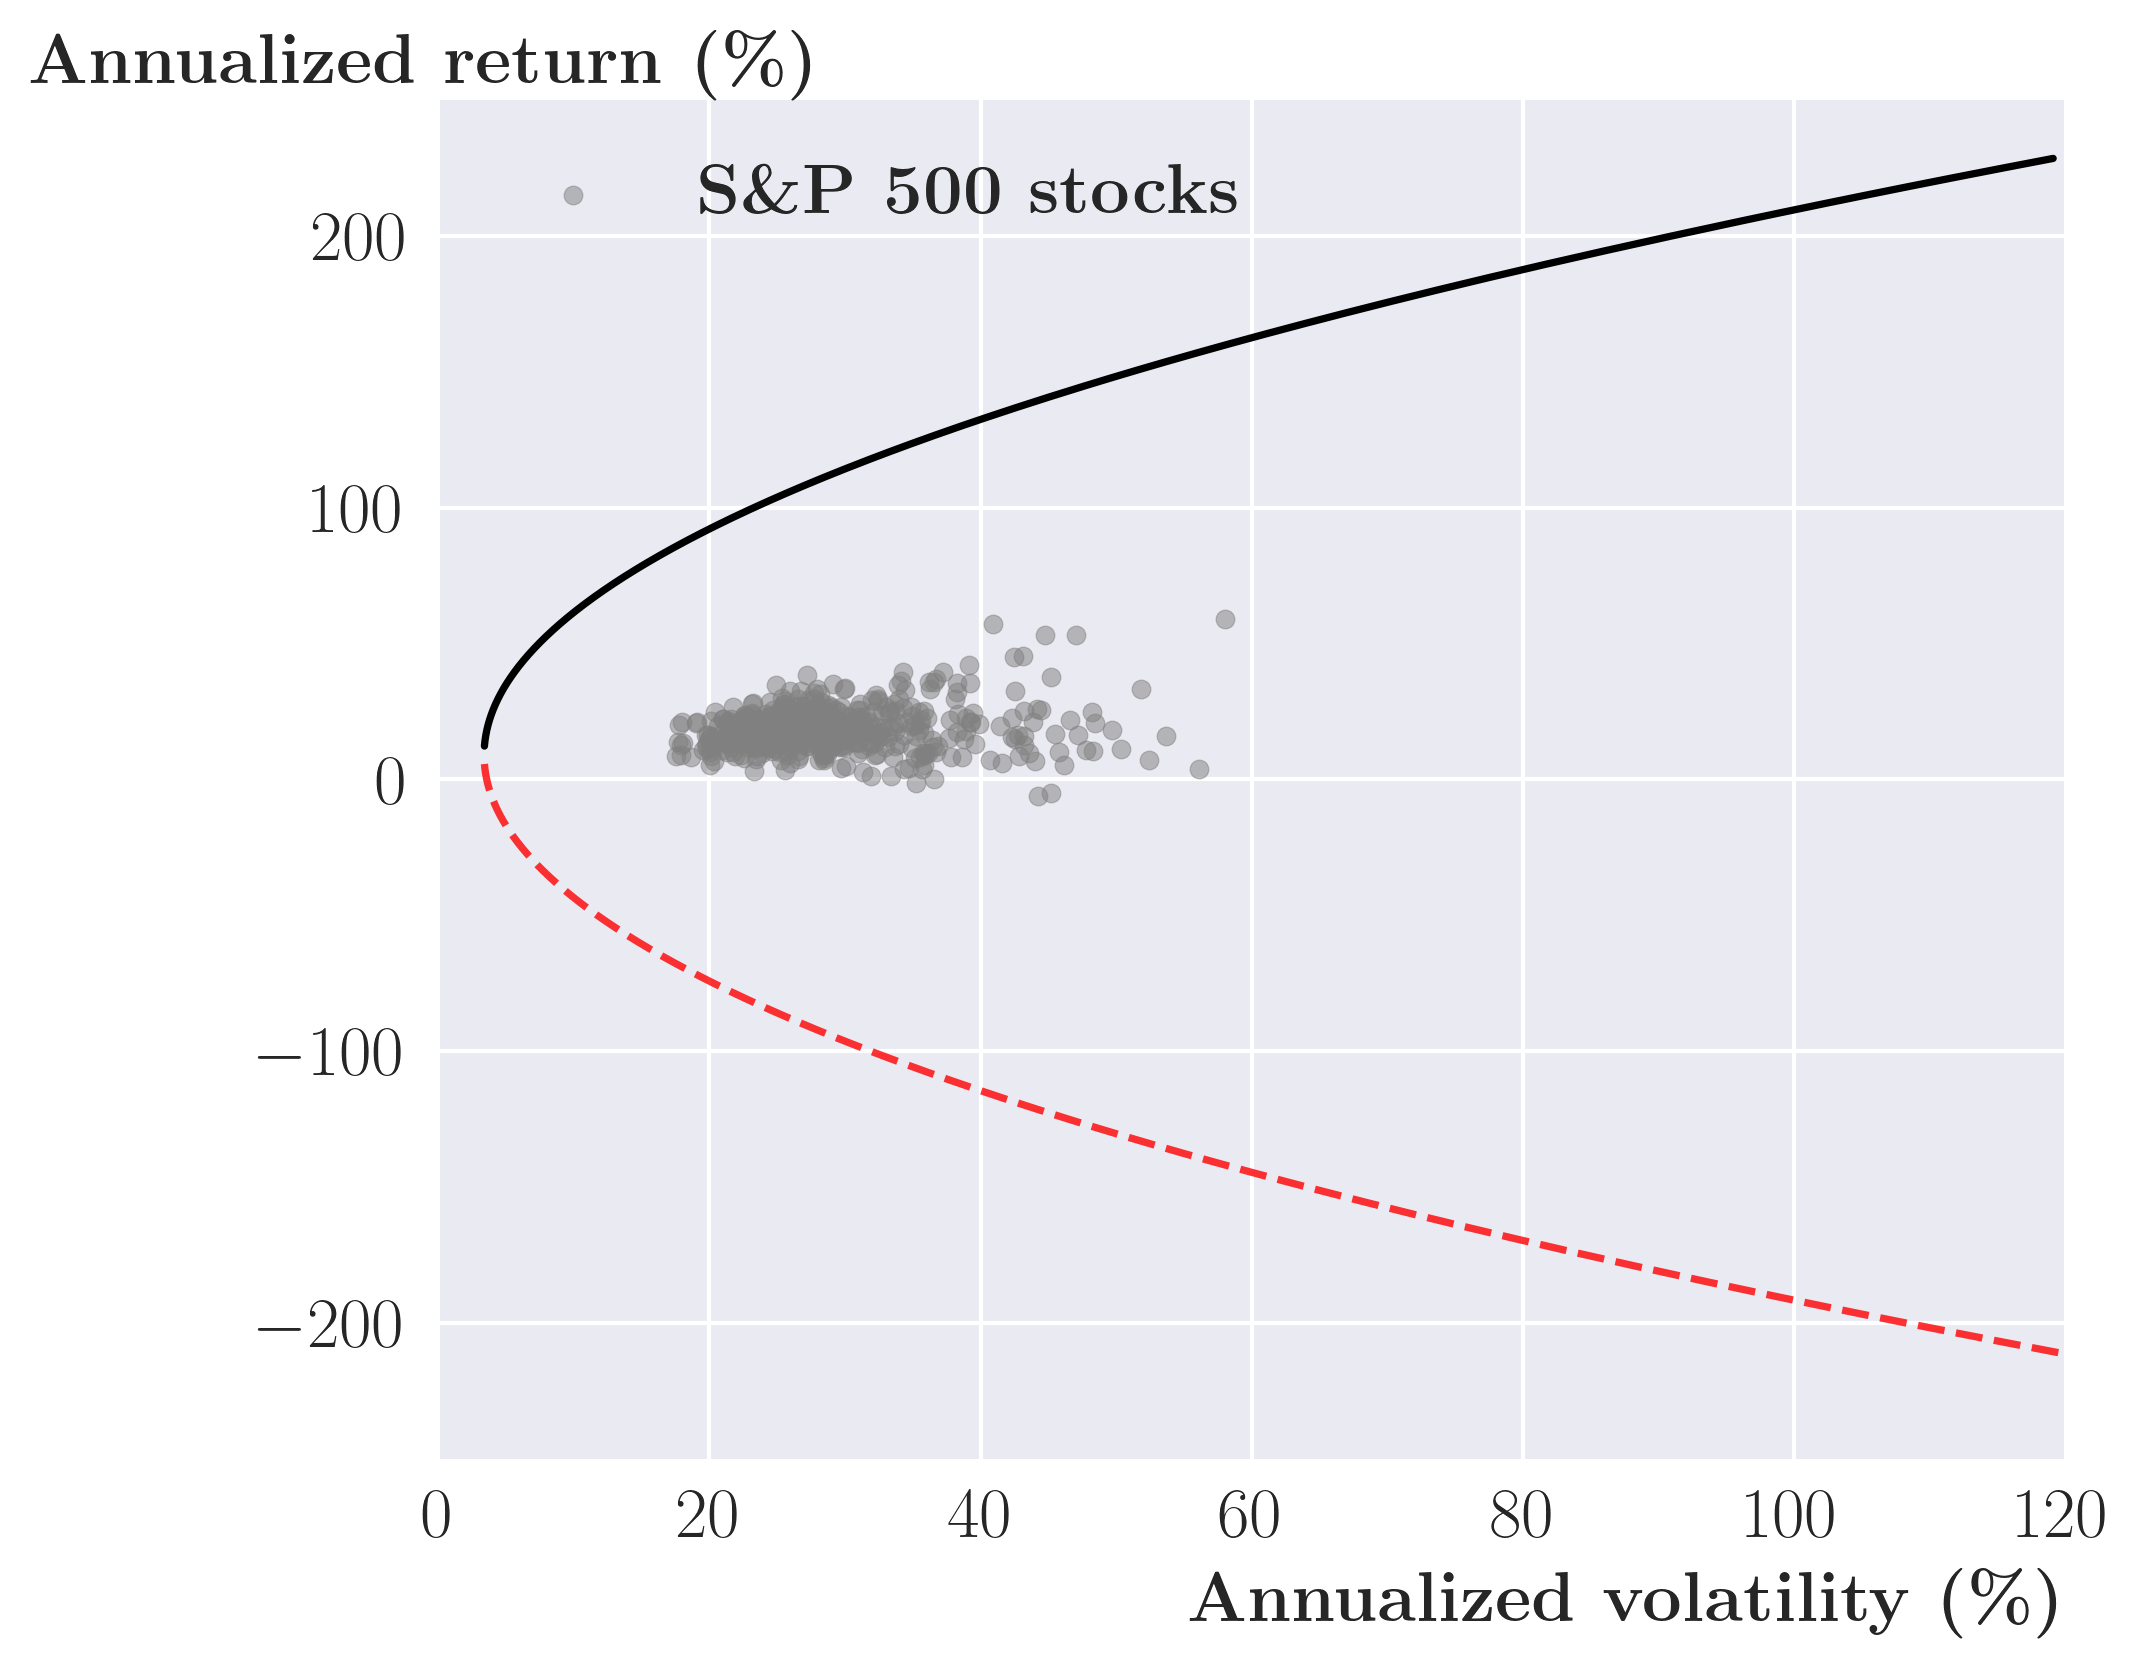

In [67]:
s = 20
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=300)
ax.scatter(std, mu, color="grey", label=r"\textbf{S\&P 500 stocks}", s=s, alpha=.5)
ax.plot(frontier_std, frontier_mu, zorder=1, color="black")
ax.plot(lower_frontier_std, lower_frontier_mu, zorder=1, alpha = 0.8, color="red", linestyle="dashed")
ax.set_xlabel(r"\textbf{Annualized volatility (\%)}",loc='right')
ax.set_ylabel(r"\textbf{Annualized return (\%)}",loc='top', rotation = 0, labelpad = -135)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=120)
ax.set_ylim(ymax=250)
ax.set_ylim(ymin=-250)
ax.legend()
#fig.savefig('feasible_set.png', bbox_inches="tight")

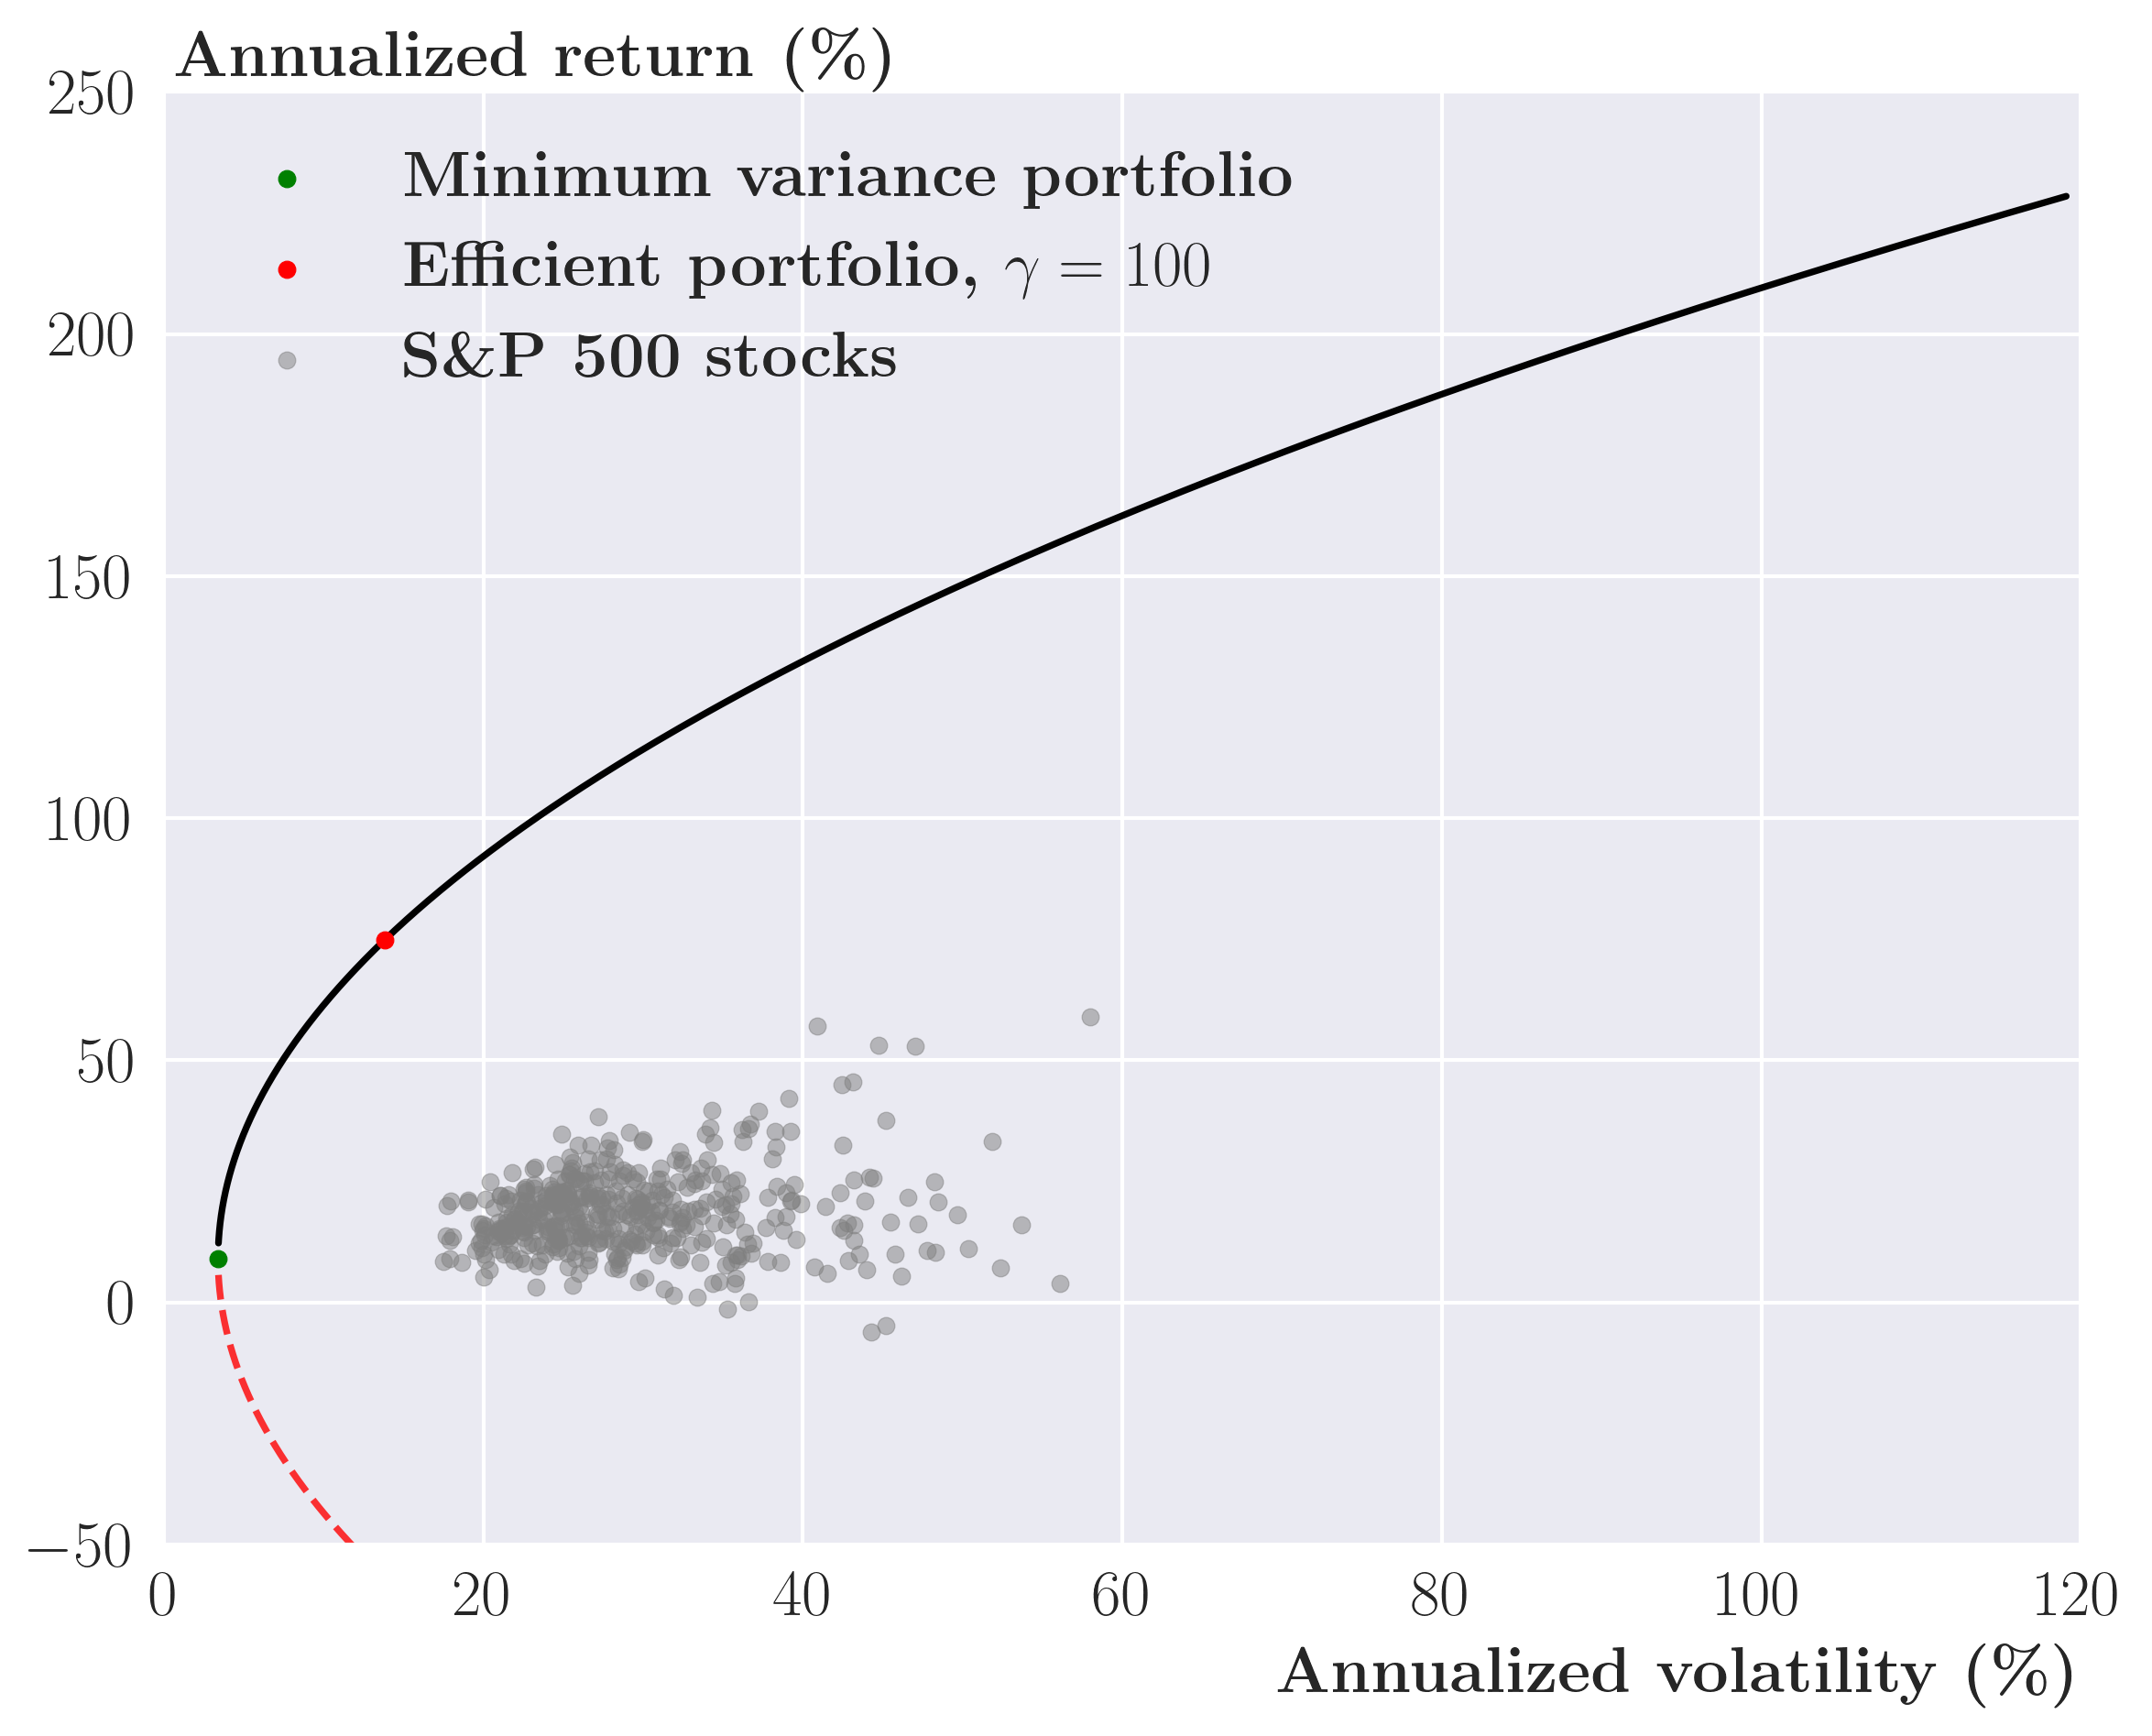

In [68]:
s = 20
fig, ax = plt.subplots(1, 1, figsize=(9, 7), dpi=300)
ax.scatter(port_std(v_t_mvp), dot(mu.T, v_t_mvp), color= "green", s=s, zorder=2, label=r"\textbf{Minimum variance portfolio}")
ax.scatter(port_std(v_t_eff), dot(mu.T, v_t_eff), color="red", s=s, zorder=2, label=r"\textbf{Efficient portfolio, $\gamma = 100$}")
ax.scatter(std, mu, color="grey", label=r"\textbf{S\&P 500 stocks}", s=s, alpha=.5)
ax.plot(frontier_std, frontier_mu, zorder=1, color="black")
ax.plot(lower_frontier_std, lower_frontier_mu, zorder=0, alpha = 0.8, color="red", linestyle="dashed")
ax.set_xlabel(r"\textbf{Annualized volatility (\%)}",loc='right')
ax.set_ylabel(r"\textbf{Annualized return (\%)}",loc='top', rotation = 0, labelpad = -228)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=120)
ax.set_ylim(ymax=250)
ax.set_ylim(ymin=-50)
ax.legend(loc="upper left")
fig.savefig('theory_std_mu.png', bbox_inches="tight")

In [ ]:
eff_perf = (returns.multiply(v_t_eff, axis=1).sum(axis=1)/100+1).cumprod()
eff_mvp = (returns.multiply(v_t_mvp, axis=1).sum(axis=1)/100+1).cumprod()

In [ ]:
spx_data = yfinance.download(['SPY'], start = "2013-1-1")['Close']
spx_data = spx_data/spx_data.iloc[0]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.plot(eff_perf)
ax.plot(eff_mvp)
ax.plot(spx_data)